In [237]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque


In [238]:
# Environment dimensions
AREA_WIDTH = 600
AREA_HEIGHT = 600

# Sensor and MC Parameters
NUM_SENSORS = 20
SENSOR_CAPACITY = 6000  # Joules
MC_CAPACITY = 1000000   # Joules
MC_SPEED = 5  # m/s
CHARGING_RATE = 20  # Joules per second
MOVEMENT_COST_PER_M = 5  # Joules per meter
THRESHOLD_RATIO = 0.2    # Time window opens when energy < 20% of capacity
CHARGING_RADIUS = 50     # Radius in meters within which MC can charge multiple nodes

In [239]:
class SensorNode:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
        self.capacity = SENSOR_CAPACITY
        self.energy = random.uniform(0.1, 1.4) * SENSOR_CAPACITY  # low enough to trigger window
        self.consumption_rate = random.uniform(0.5, 2.0)  # J/s
        self.dead = False
    
    def get_location(self):
        return (self.x, self.y)

    def update_energy(self, seconds):
        if not self.dead:
            self.energy -= self.consumption_rate * seconds
            if self.energy <= 0:
                self.energy = 0
                self.dead = True

    def needs_charging(self):
        return self.energy < (THRESHOLD_RATIO * self.capacity) and not self.dead

    def charge(self, amount):
        if not self.dead:
            self.energy += amount
            if self.energy > self.capacity:
                self.energy = self.capacity


In [240]:
class MobileCharger:
    def __init__(self, base_x=300, base_y=300):
        self.x = base_x
        self.y = base_y
        self.energy = MC_CAPACITY
        self.start_pos = (base_x, base_y)

    def move_to(self, x, y):
        distance = np.linalg.norm([self.x - x, self.y - y])
        cost = distance * MOVEMENT_COST_PER_M
        if self.energy < cost:
            return False  # not enough energy to move
        self.x, self.y = x, y
        self.energy -= cost
        return True

    def charge_node(self, node):
        if self.energy <= 0 or node.dead:
            return 0
        needed = node.capacity - node.energy
        energy_to_transfer = min(needed, self.energy)
        node.charge(energy_to_transfer)
        self.energy -= energy_to_transfer
        return energy_to_transfer
        
    def charge_nodes_in_radius(self, sensors):
        """Charge all sensor nodes within the charging radius"""
        charged_nodes = []
        total_energy_transferred = 0
        
        if self.energy <= 0:
            return charged_nodes, 0
            
        # Find sensors within the charging radius that need charging
        for sensor in sensors:
            if sensor.dead:
                continue
                
            distance = np.linalg.norm([self.x - sensor.x, self.y - sensor.y])
            if distance <= CHARGING_RADIUS and sensor.energy < sensor.capacity:
                needed = sensor.capacity - sensor.energy
                # Reduce charging efficiency with distance
                efficiency = max(0.3, 1 - (distance / CHARGING_RADIUS) * 0.7)  # 30% to 100% efficiency
                max_transfer = min(needed, self.energy)
                energy_to_transfer = max_transfer * efficiency
                
                if energy_to_transfer > 0:
                    sensor.charge(energy_to_transfer)
                    self.energy -= energy_to_transfer
                    total_energy_transferred += energy_to_transfer
                    charged_nodes.append(sensor.id)
                    
                    if self.energy <= 0:
                        break
                        
        return charged_nodes, total_energy_transferred

In [241]:
def initialize_environment(num_sensors=NUM_SENSORS):
    sensors = []
    for i in range(num_sensors):
        x = random.uniform(0, AREA_WIDTH)
        y = random.uniform(0, AREA_HEIGHT)
        sensors.append(SensorNode(i, x, y))
    mc = MobileCharger()
    return sensors, mc


In [242]:
def plot_environment(sensors, mc):
    alive_x = [s.x for s in sensors if not s.dead]
    alive_y = [s.y for s in sensors if not s.dead]
    dead_x = [s.x for s in sensors if s.dead]
    dead_y = [s.y for s in sensors if s.dead]

    plt.figure(figsize=(8, 8))
    plt.scatter(alive_x, alive_y, c='green', label='Alive Sensors')
    plt.scatter(dead_x, dead_y, c='red', label='Dead Sensors')
    plt.scatter(mc.x, mc.y, c='blue', label='Mobile Charger (MC)', marker='X', s=100)
    plt.scatter(300, 300, c='black', label='Base Station', marker='s')
    
    # Draw charging radius
    circle = plt.Circle((mc.x, mc.y), CHARGING_RADIUS, color='blue', fill=False, linestyle='--', alpha=0.5)
    plt.gcf().gca().add_artist(circle)
    
    # Highlight nodes in charging range
    in_range_x = []
    in_range_y = []
    for s in sensors:
        if not s.dead:
            distance = np.linalg.norm([mc.x - s.x, mc.y - s.y])
            if distance <= CHARGING_RADIUS:
                in_range_x.append(s.x)
                in_range_y.append(s.y)
    
    if in_range_x:
        plt.scatter(in_range_x, in_range_y, c='yellow', edgecolors='orange', 
                   label='In Charging Range', s=80, zorder=3)
    
    plt.legend()
    plt.title("WRSN Environment")
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.show()

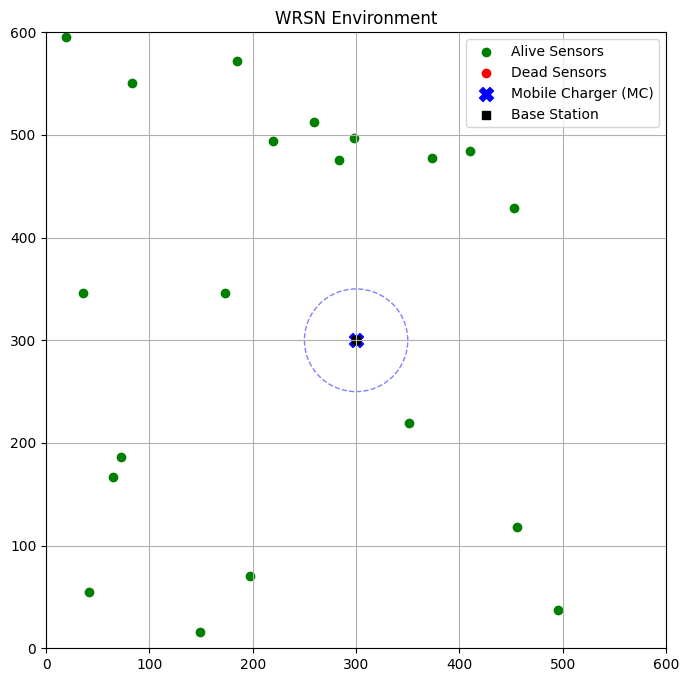

In [243]:
sensors, mc = initialize_environment()
plot_environment(sensors, mc)


In [244]:
def simulate_step(sensors, mc, time_step=10):
    # 1. Update energy of all sensors
    for s in sensors:
        s.update_energy(time_step)

    # 2. Filter sensors needing charging and still alive
    to_charge = [s for s in sensors if s.needs_charging()]
    if not to_charge:
        print("No sensor needs charging right now.")
        return False

    # 3. Select next sensor using greedy strategy (closest one)
    to_charge.sort(key=lambda s: np.linalg.norm([mc.x - s.x, mc.y - s.y]))
    target = to_charge[0]
    
    # 4. Move to sensor
    if not mc.move_to(target.x, target.y):
        print("MC does not have enough energy to move.")
        return False

    # 5. Charge all sensors within radius
    charged_nodes, total_energy = mc.charge_nodes_in_radius(sensors)
    
    if charged_nodes:
        print(f"Charged {len(charged_nodes)} sensors with total {total_energy:.2f} J")
        print(f"Sensor IDs charged: {charged_nodes}")
    else:
        print("No sensors were charged in this step.")

    return True

In [245]:
def run_simulation(sensors, mc, max_steps=1000, time_step=10, visualize_every=50):
    for step in range(max_steps):
        print(f"--- Step {step} ---")
        result = simulate_step(sensors, mc, time_step)
        if not result:
            print("Simulation ended (MC depleted or no tasks).")
            break

        if step % visualize_every == 0:
            plot_environment(sensors, mc)

    # Final stats
    dead = sum(1 for s in sensors if s.dead)
    alive = NUM_SENSORS - dead
    print(f"Simulation Complete. Alive: {alive}, Dead: {dead}")
    print(f"MC remaining energy: {mc.energy:.2f} J")


--- Step 0 ---
Charged 2 sensors with total 7645.08 J
Sensor IDs charged: [14, 18]


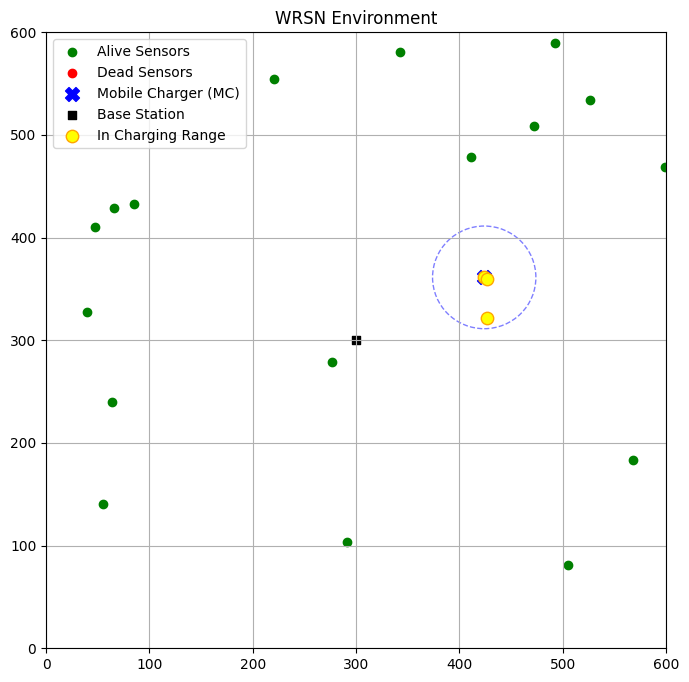

--- Step 1 ---
Charged 1 sensors with total 5049.43 J
Sensor IDs charged: [12]
--- Step 2 ---
No sensor needs charging right now.
Simulation ended (MC depleted or no tasks).
Simulation Complete. Alive: 20, Dead: 0
MC remaining energy: 984791.67 J


In [246]:
sensors, mc = initialize_environment()
run_simulation(sensors, mc, max_steps=200, time_step=15)


In [247]:
def get_state_vector(sensors, mc):
    state = []

    # 1. Global state: MC energy (normalized)
    mc_energy_ratio = mc.energy / MC_CAPACITY
    state.append(mc_energy_ratio)

    for s in sensors:
        # 2. Distance to the MC (normalized)
        distance = np.linalg.norm([mc.x - s.x, mc.y - s.y])
        max_dist = np.linalg.norm([AREA_WIDTH, AREA_HEIGHT])
        distance_norm = distance / max_dist

        # 3. Residual energy (normalized)
        energy_ratio = s.energy / s.capacity

        # 4. Time window status (1 if open)
        window_open = 1 if s.needs_charging() else 0

        # 5. Time left before death (normalized)
        if s.dead or s.consumption_rate == 0:
            time_left_ratio = 0
        else:
            time_left = s.energy / s.consumption_rate
            time_left_ratio = min(time_left / 1000, 1)  # cap to avoid large numbers

        # Append sensor state
        state += [distance_norm, energy_ratio, window_open, time_left_ratio]

    return np.array(state, dtype=np.float32)


In [248]:
sensors, mc = initialize_environment()
state = get_state_vector(sensors, mc)

print(f"State vector shape: {state.shape}")
print(f"Sample values:\n{state[:10]} ...")


State vector shape: (81,)
Sample values:
[1.         0.38875887 1.2503357  0.         1.         0.19355184
 1.3565485  0.         1.         0.17855892] ...


In [249]:
sensors, mc = initialize_environment()


In [250]:
def get_valid_actions(sensors, mc):
    actions = []
    for i, sensor in enumerate(sensors):
        if sensor.needs_charging() and not sensor.dead:
            actions.append(i)
    actions.append(NUM_SENSORS)  # action to return to base
    return actions


In [251]:
def explain_action(action):
    if action == NUM_SENSORS:
        return "Return to base station"
    else:
        return f"Charge sensor {action}"


In [252]:
sensors, mc = initialize_environment()
valid_actions = get_valid_actions(sensors, mc)

print("Valid actions:", valid_actions)
for a in valid_actions:
    print(f"Action {a}: {explain_action(a)}")


Valid actions: [8, 20]
Action 8: Charge sensor 8
Action 20: Return to base station


In [253]:
def calculate_reward(prev_dead_count, curr_dead_count, distance_moved, charged=False):
    move_penalty = - (distance_moved / 100)  # less harsh (dividing by 100 not 10)

    new_deaths = curr_dead_count - prev_dead_count
    death_penalty = new_deaths * -50  # keep this harsh

    charge_bonus = 0
    if charged:
        charge_bonus = 10  # strong positive signal when it charges

    return move_penalty + death_penalty + charge_bonus


In [254]:
def count_dead_sensors(sensors):
    return sum(1 for s in sensors if s.dead)


In [255]:
sensors, mc = initialize_environment()

prev_dead = count_dead_sensors(sensors)

# Simulate one step manually
target = sensors[5]
distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
mc.move_to(target.x, target.y)
mc.charge_node(target)

# Simulate energy drop
for s in sensors:
    s.update_energy(30)

curr_dead = count_dead_sensors(sensors)

reward = calculate_reward(prev_dead, curr_dead, distance)
print(f"Reward: {reward:.2f}")


Reward: -1.52


In [256]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [257]:
# Create network instance
state_size = 1 + NUM_SENSORS * 4
action_size = NUM_SENSORS + 1  # Include "return to base"
model = QNetwork(state_size, action_size)

# Dummy state
dummy_state = get_state_vector(sensors, mc)
dummy_state_tensor = torch.tensor(dummy_state, dtype=torch.float32).unsqueeze(0)  # batch of 1

q_values = model(dummy_state_tensor)
print("Q-values shape:", q_values.shape)
print("Q-values:", q_values)


Q-values shape: torch.Size([1, 21])
Q-values: tensor([[-0.0429, -0.1079,  0.0710, -0.0134, -0.2259,  0.0345,  0.0289, -0.0315,
         -0.0266,  0.0083,  0.1092, -0.0676, -0.1816,  0.0121, -0.1470,  0.1283,
          0.0500, -0.0031, -0.0046, -0.1826, -0.0050]],
       grad_fn=<AddmmBackward0>)


In [258]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


In [259]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.9, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # sync weights

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()

    def act(self, state, valid_actions):
        if np.random.rand() < self.epsilon:
            return random.choice(valid_actions)  # Explore
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            q_values = q_values.squeeze().detach().numpy()

            # Mask invalid actions
            masked_q = np.full(self.action_size, -np.inf)
            masked_q[valid_actions] = q_values[valid_actions]

            return int(np.argmax(masked_q))  # Exploit best valid action

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Compute target Q-values
        with torch.no_grad():
            next_q_vals = self.target_network(next_states).max(1)[0]
            targets = rewards + (1 - dones) * self.gamma * next_q_vals

        current_q_vals = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        loss = self.loss_fn(current_q_vals, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [260]:
state_size = 1 + NUM_SENSORS * 4
action_size = NUM_SENSORS + 1
agent = DQNAgent(state_size, action_size)

state = get_state_vector(sensors, mc)
valid_actions = get_valid_actions(sensors, mc)

action = agent.act(state, valid_actions)
print(f"Agent chose action: {action}")


Agent chose action: 0


In [261]:
def evaluate_agent(agent, episodes=5, max_steps=200, time_step=30):
    print("\n--- Evaluation Mode (Epsilon = 0.0) ---")
    agent.epsilon = 0.0  # greedy policy
    results = []

    for ep in range(episodes):
        sensors, mc = initialize_environment()
        state = get_state_vector(sensors, mc)
        total_reward = 0
        dead_before = count_dead_sensors(sensors)

        print(f"\nEpisode {ep+1}:")

        for step in range(max_steps):
            valid_actions = get_valid_actions(sensors, mc)
            if not valid_actions:
                print(f"  Step {step}: No valid actions left.")
                break

            action = agent.act(state, valid_actions)
            action_desc = explain_action(action)
            print(f"  Step {step}: Action {action} → {action_desc}")

            if action == NUM_SENSORS:
                mc.move_to(300, 300)
                mc.energy = MC_CAPACITY
                reward = -0.1
                next_state = get_state_vector(sensors, mc)
            else:
                target = sensors[action]
                distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
                move_ok = mc.move_to(target.x, target.y)

                if not move_ok:
                    reward = -5
                    break
                else:
                    charged = mc.charge_node(target)

                    for s in sensors:
                        s.update_energy(time_step)

                    dead_after = count_dead_sensors(sensors)
                    reward = calculate_reward(dead_before, dead_after, distance)
                    if charged > 0:
                        reward += 15.0

                    dead_before = dead_after
                    next_state = get_state_vector(sensors, mc)

            state = next_state
            total_reward += reward

        dead_final = count_dead_sensors(sensors)
        print(f"Episode {ep+1} Complete → Total Reward: {total_reward:.2f}, Dead Sensors: {dead_final}")
        charged_count = sum(1 for s in sensors if s.energy > 0.95 * s.capacity)
        print(f"  Sensors fully charged: {charged_count}")

        results.append((total_reward, dead_final))

    return results


In [262]:
def train_dqn(agent, episodes=500, max_steps=200, batch_size=64, target_update=10):
    episode_rewards = []

    for ep in range(episodes):
        sensors, mc = initialize_environment()
        state = get_state_vector(sensors, mc)
        total_reward = 0
        done = False
        dead_before = count_dead_sensors(sensors)

        for step in range(max_steps):
            valid_actions = get_valid_actions(sensors, mc)
            if not valid_actions:
                print(f"  Step {step}: No valid actions available.")
                break

            action = agent.act(state, valid_actions)
            action_desc = explain_action(action)
            print(f"  Step {step}: Action {action} → {action_desc}")

            # --- Execute action ---
            if action == NUM_SENSORS:
                mc.move_to(300, 300)
                mc.energy = MC_CAPACITY  # recharge fully
                reward = -1.0
                next_state = get_state_vector(sensors, mc)
                done = False
            else:
                target = sensors[action]
                distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
                move_ok = mc.move_to(target.x, target.y)

                if not move_ok:
                    reward = -5
                    done = True
                else:
                    # Charge all nodes in radius instead of just one
                    charged_nodes, total_energy = mc.charge_nodes_in_radius(sensors)
                    
                    # Update reward based on how many nodes were charged
                    num_charged = len(charged_nodes)

                    # Simulate energy drain
                    for s in sensors:
                        s.update_energy(30)  # larger step to apply Fix 2

                    dead_after = count_dead_sensors(sensors)
                    base_reward = calculate_reward(dead_before, dead_after, distance)
                    
                    # Bonus for charging multiple nodes
                    multi_charge_bonus = 0
                    if num_charged > 0:
                        multi_charge_bonus = 15.0 + (num_charged - 1) * 8.0  # Extra bonus for each additional node
                    
                    reward = base_reward + multi_charge_bonus
                    
                    # Update the dead count
                    dead_before = dead_after
                    done = mc.energy <= 0 or dead_after == NUM_SENSORS

                next_state = get_state_vector(sensors, mc)

            # Store and train
            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train(batch_size)

            state = next_state
            total_reward += reward

            if done:
                break

        agent.decay_epsilon()

        # Periodically update target network
        if ep % target_update == 0:
            agent.update_target_network()

        # Final episode-level bonus
        if not done and dead_before == 0:
            total_reward += 25  # bonus for keeping all sensors alive

        # Log results
        dead_now = count_dead_sensors(sensors)
        print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.2f}, Dead: {dead_now}, Epsilon: {agent.epsilon:.3f}")

        episode_rewards.append(total_reward)

    return episode_rewards


In [263]:
state_size = 1 + NUM_SENSORS * 4
action_size = NUM_SENSORS + 1
agent = DQNAgent(state_size, action_size)

rewards = train_dqn(agent, episodes=100)

  Step 0: Action 19 → Charge sensor 19
  Step 1: Action 4 → Charge sensor 4
  Step 2: Action 20 → Return to base station
  Step 3: Action 1 → Charge sensor 1
  Step 4: Action 20 → Return to base station
  Step 5: Action 20 → Return to base station
  Step 6: Action 20 → Return to base station
  Step 7: Action 20 → Return to base station
  Step 8: Action 20 → Return to base station
  Step 9: Action 20 → Return to base station
  Step 10: Action 20 → Return to base station
  Step 11: Action 20 → Return to base station
  Step 12: Action 20 → Return to base station
  Step 13: Action 20 → Return to base station
  Step 14: Action 20 → Return to base station
  Step 15: Action 20 → Return to base station
  Step 16: Action 20 → Return to base station
  Step 17: Action 20 → Return to base station
  Step 18: Action 20 → Return to base station
  Step 19: Action 20 → Return to base station
  Step 20: Action 20 → Return to base station
  Step 21: Action 20 → Return to base station
  Step 22: Action 20

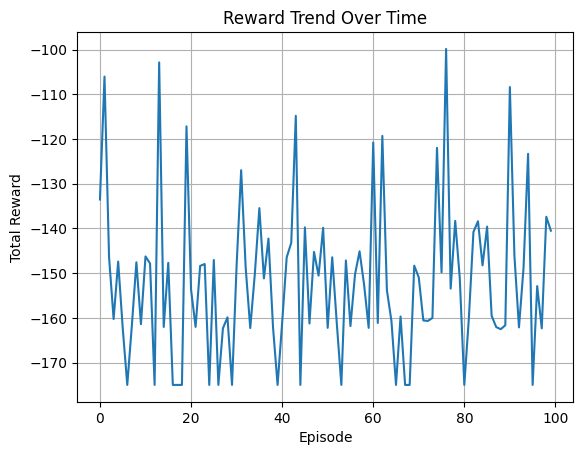

In [264]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Trend Over Time")
plt.grid(True)
plt.show()


In [265]:
# Step 3: Evaluate the trained agent
results = evaluate_agent(agent, episodes=3)


--- Evaluation Mode (Epsilon = 0.0) ---

Episode 1:
  Step 0: Action 8 → Charge sensor 8
  Step 1: Action 0 → Charge sensor 0
  Step 2: Action 20 → Return to base station
  Step 3: Action 20 → Return to base station
  Step 4: Action 20 → Return to base station
  Step 5: Action 20 → Return to base station
  Step 6: Action 20 → Return to base station
  Step 7: Action 20 → Return to base station
  Step 8: Action 20 → Return to base station
  Step 9: Action 20 → Return to base station
  Step 10: Action 20 → Return to base station
  Step 11: Action 20 → Return to base station
  Step 12: Action 20 → Return to base station
  Step 13: Action 20 → Return to base station
  Step 14: Action 20 → Return to base station
  Step 15: Action 20 → Return to base station
  Step 16: Action 20 → Return to base station
  Step 17: Action 20 → Return to base station
  Step 18: Action 20 → Return to base station
  Step 19: Action 20 → Return to base station
  Step 20: Action 20 → Return to base station
  Step 

In [266]:
# Step 4: Print average performance
rewards_eval, deaths_eval = zip(*results)
print("\n--- Evaluation Summary ---")
print("Average Evaluation Reward:", np.mean(rewards_eval))
print("Average Dead Sensors:", np.mean(deaths_eval))


--- Evaluation Summary ---
Average Evaluation Reward: -2.1199059100757456
Average Dead Sensors: 0.0


--- Step 1 ---
Charged 2 sensors with total 5885.36 J


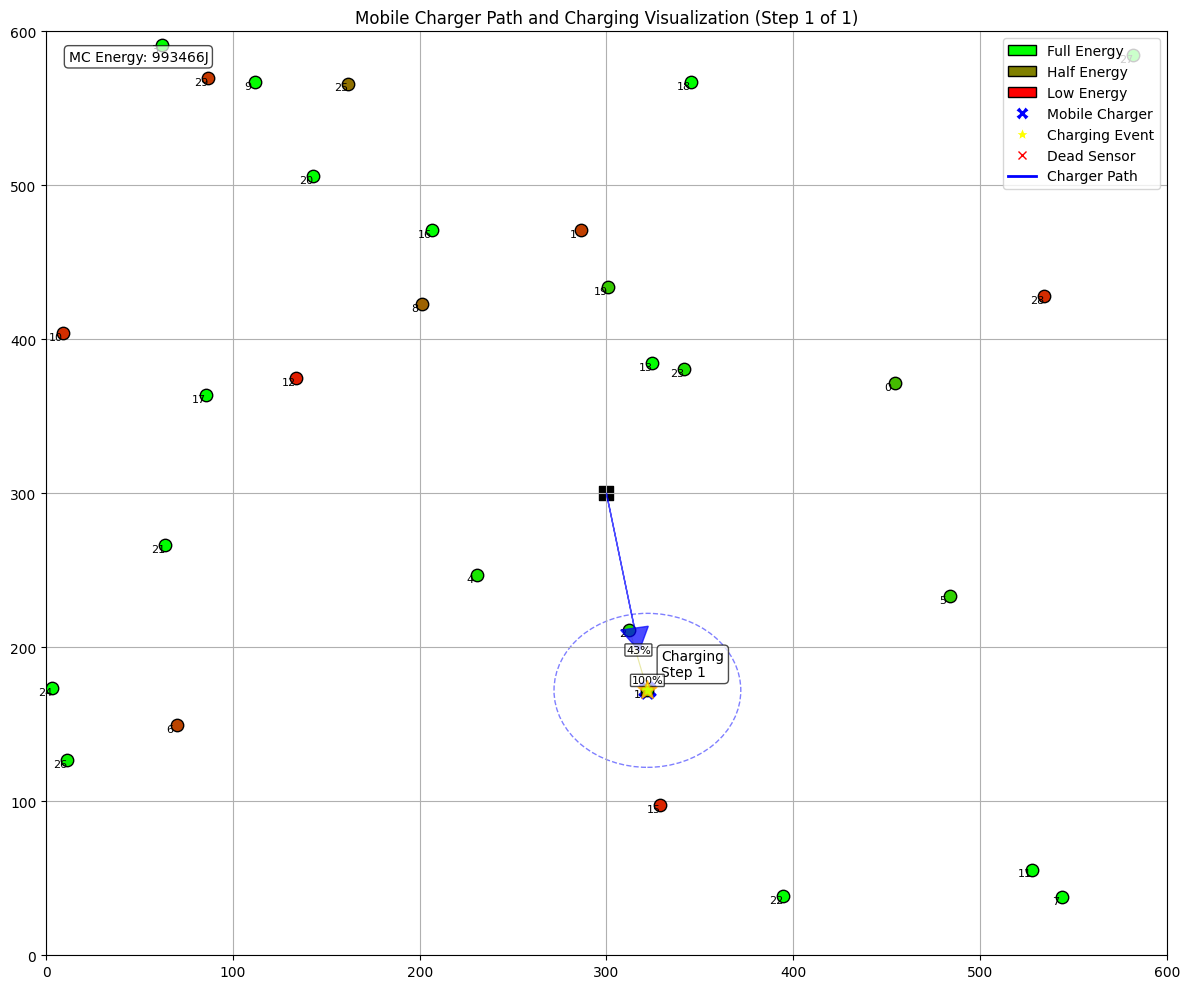

--- Step 2 ---
Charged 1 sensors with total 5130.96 J


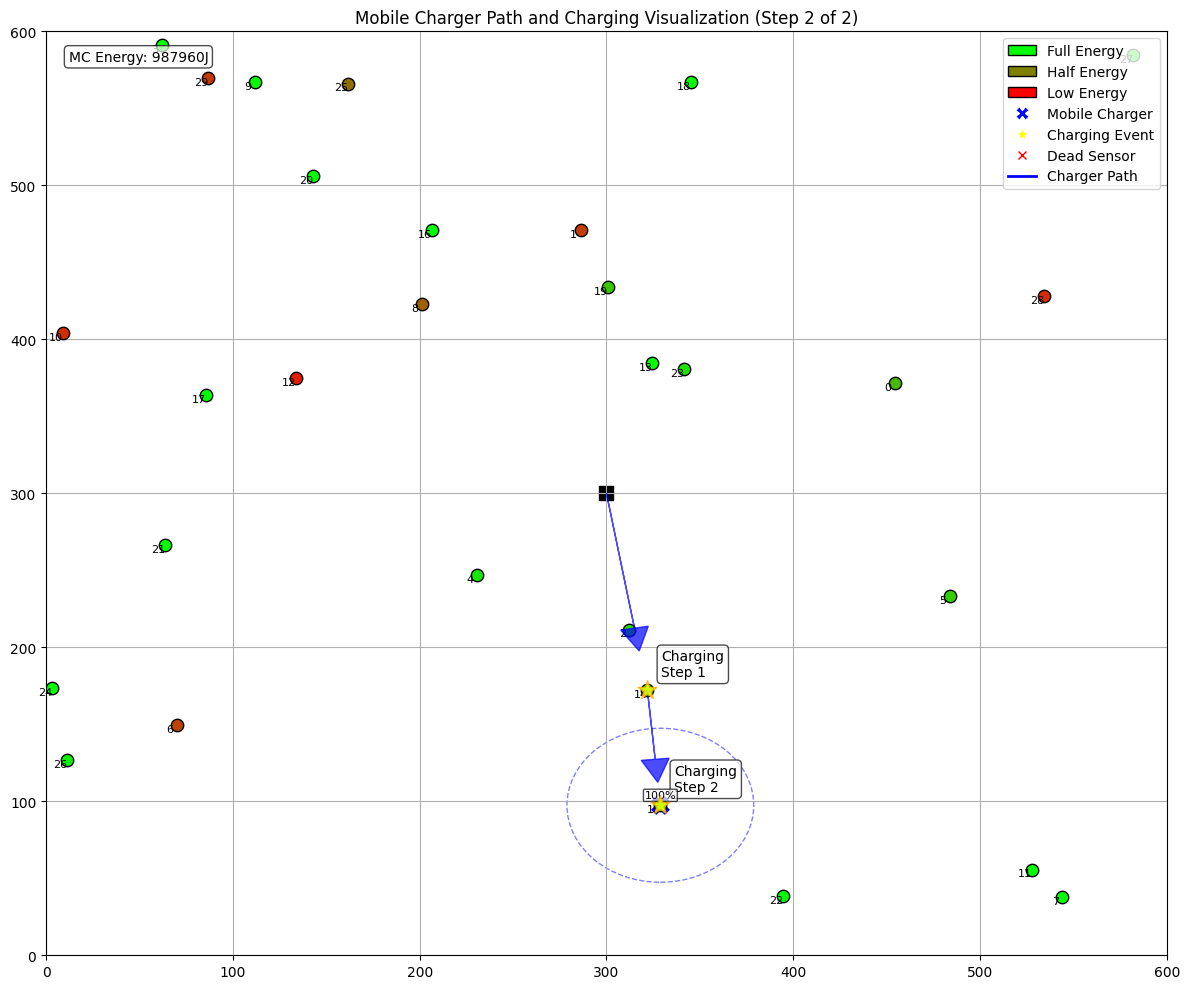

--- Step 3 ---
Charged 1 sensors with total 5324.25 J


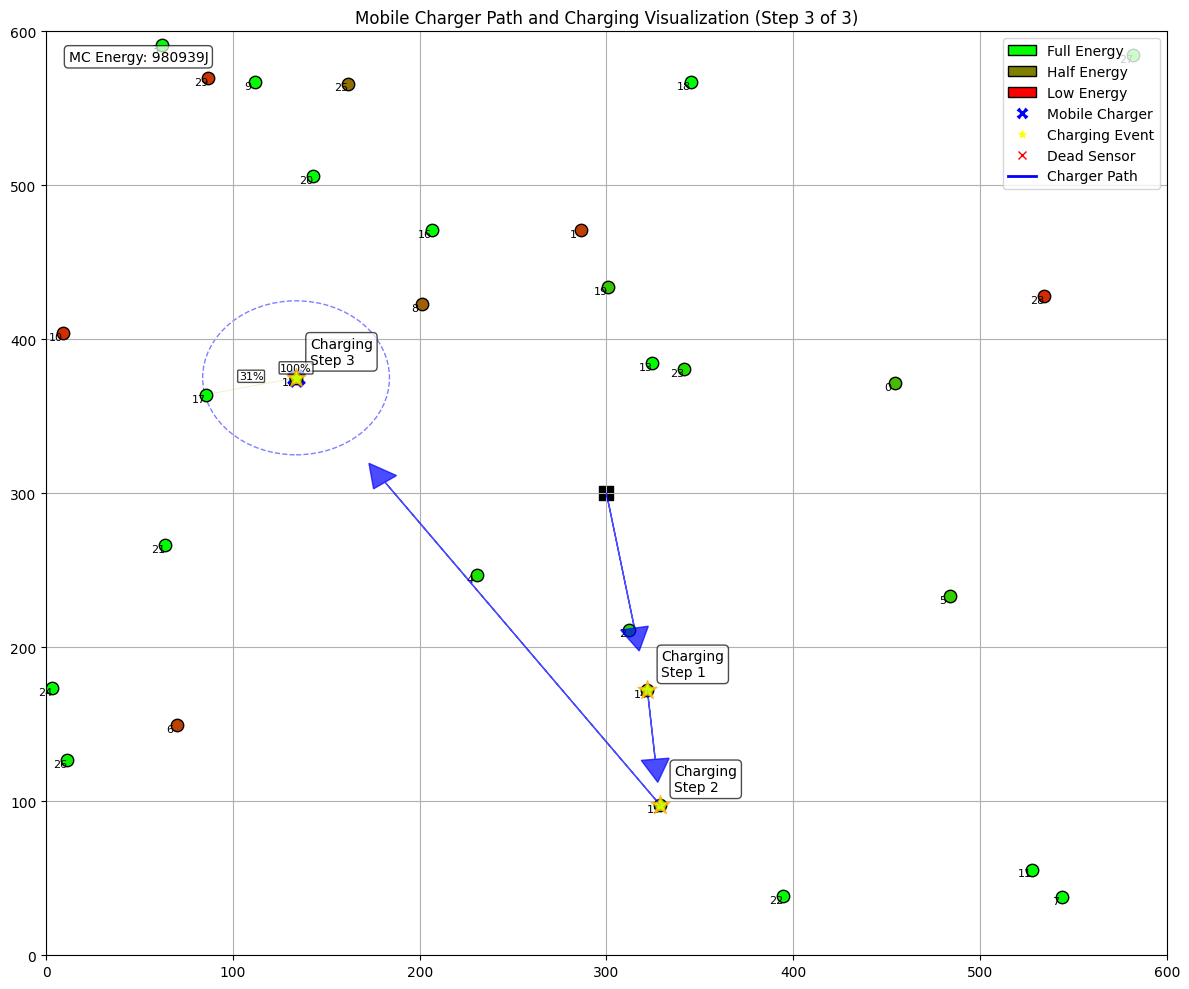

--- Step 4 ---
Charged 1 sensors with total 4934.99 J


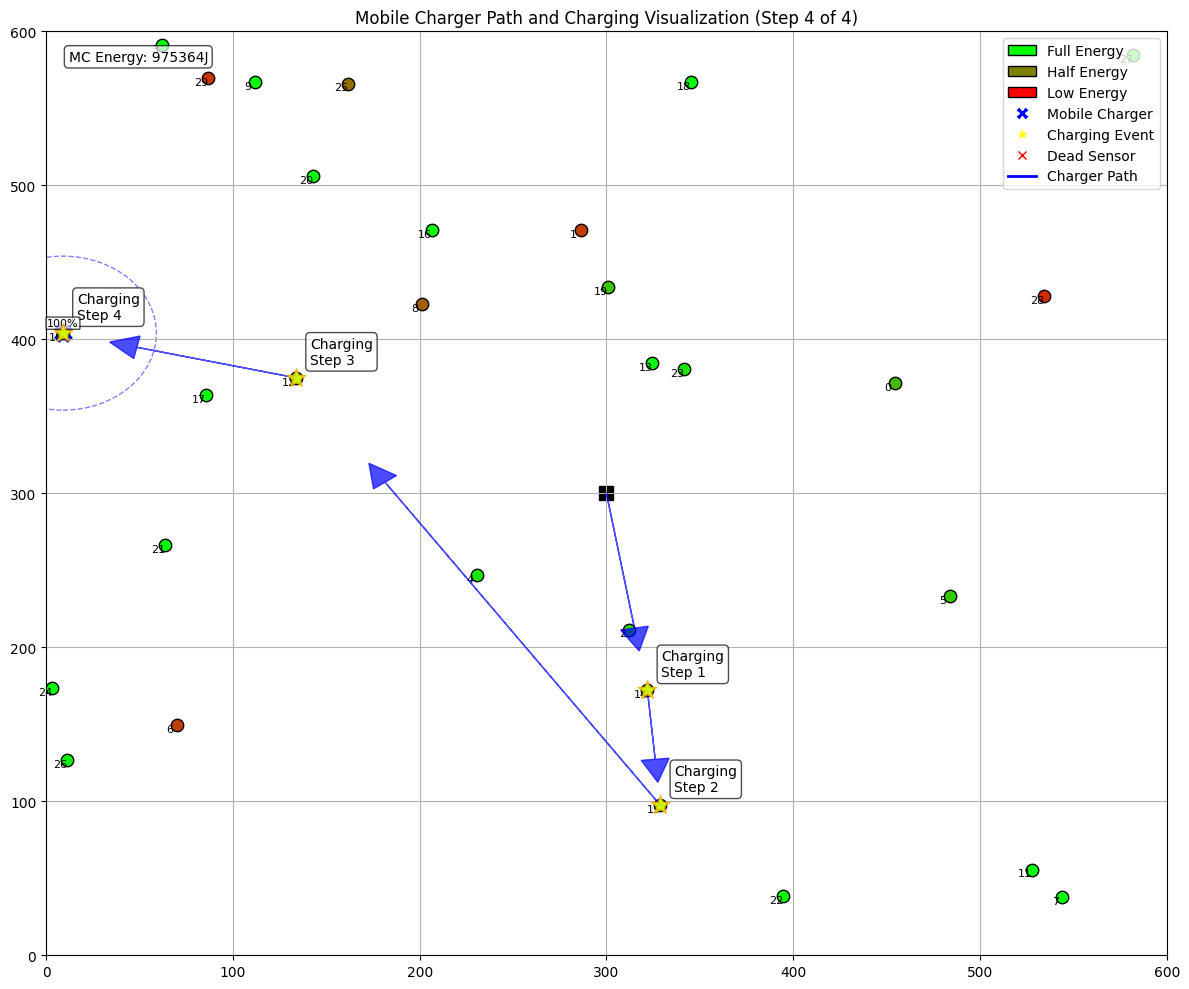

--- Step 5 ---
Charged 1 sensors with total 4986.33 J


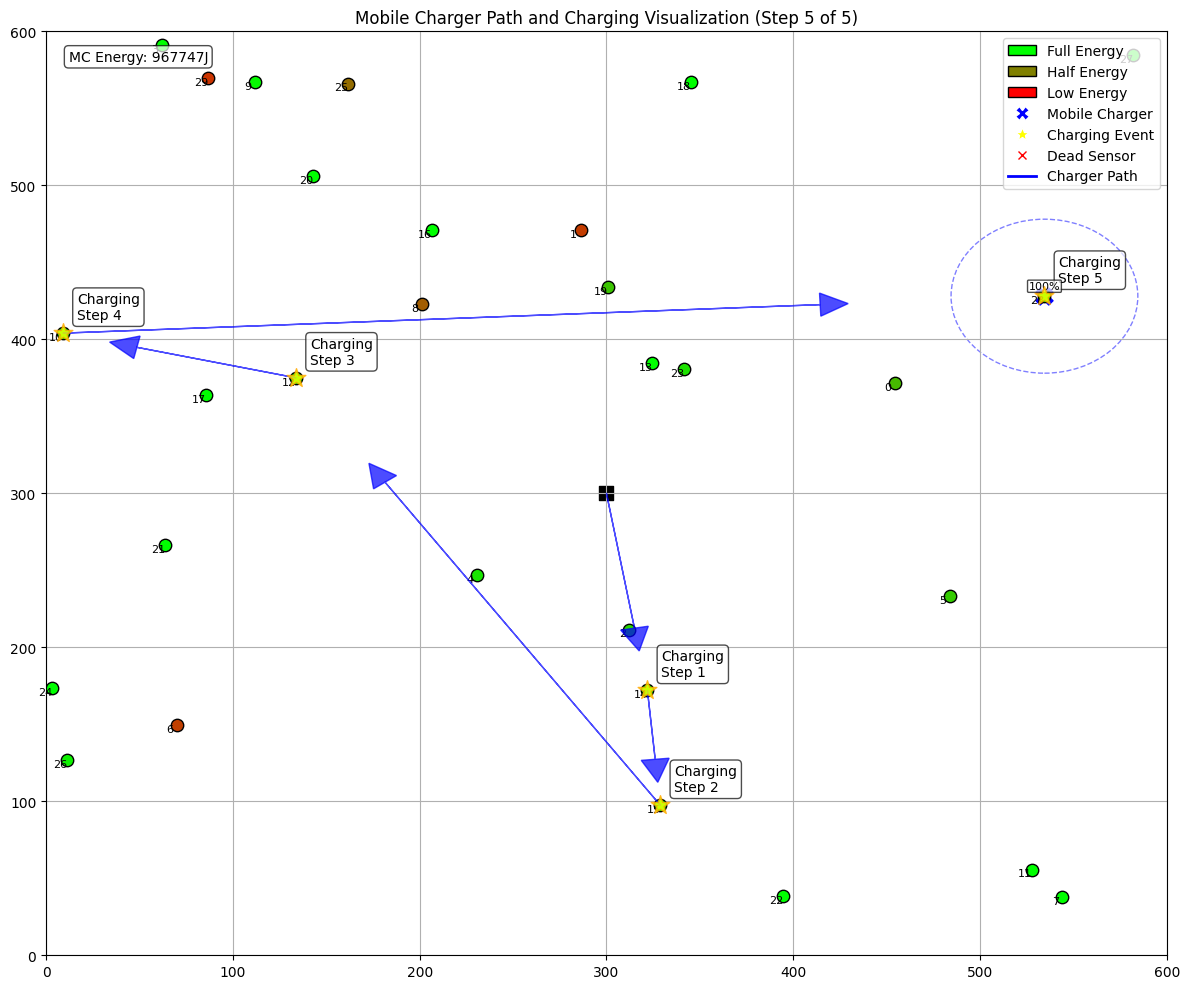

--- Step 6 ---
No sensor needs charging right now.

Energy Change Summary:
Sensor 0: 4399.5J → 4360.7J (-38.8J) - DEPLETED
Sensor 1: 1510.5J → 1407.0J (-103.5J) - DEPLETED
Sensor 2: 4425.0J → 5015.3J (+590.3J) - CHARGED
Sensor 3: 6652.3J → 6574.2J (-78.0J) - DEPLETED
Sensor 4: 5444.2J → 5401.4J (-42.9J) - DEPLETED
Sensor 5: 4915.1J → 4783.9J (-131.2J) - DEPLETED
Sensor 6: 1632.4J → 1489.6J (-142.7J) - DEPLETED
Sensor 7: 7546.9J → 7464.3J (-82.6J) - DEPLETED
Sensor 8: 2324.8J → 2178.7J (-146.1J) - DEPLETED
Sensor 9: 5932.0J → 5885.5J (-46.5J) - DEPLETED
Sensor 10: 1106.9J → 5972.1J (+4865.3J) - CHARGED
Sensor 11: 6225.6J → 6096.2J (-129.4J) - DEPLETED
Sensor 12: 705.7J → 5955.1J (+5249.4J) - CHARGED
Sensor 13: 6574.2J → 6479.5J (-94.7J) - DEPLETED
Sensor 14: 793.2J → 5934.7J (+5141.6J) - CHARGED
Sensor 15: 880.3J → 5954.9J (+5074.6J) - CHARGED
Sensor 16: 6332.6J → 6211.0J (-121.6J) - DEPLETED
Sensor 17: 7336.6J → 7245.4J (-91.2J) - DEPLETED
Sensor 18: 7336.7J → 7205.5J (-131.2J) - DEPLE

In [ ]:
def visualize_charger_path(num_steps=15, time_step=10, show_step_by_step=True):
    """
    Visualizes the path of the mobile charger and how sensors get charged over time.
    
    Args:
        num_steps: Number of simulation steps to run
        time_step: Time between each step (impacts energy consumption)
        show_step_by_step: If True, shows each step; if False, only shows final state with full path
    """
    # Initialize environment with more sensors for better visualization
    sensors, mc = initialize_environment(num_sensors=30)
    
    # Create lists to store path and charging information
    path_x = [mc.x]
    path_y = [mc.y]
    charging_events = []  # List to store charging positions
    
    # Track initial energy states
    initial_energy = {s.id: s.energy for s in sensors}
    
    # Run simulation for specified steps
    for step in range(num_steps):
        print(f"--- Step {step+1} ---")
        
        # Filter sensors needing charging
        to_charge = [s for s in sensors if s.needs_charging()]
        if not to_charge:
            print("No sensor needs charging right now.")
            break
            
        # Select next sensor using greedy strategy (closest one)
        to_charge.sort(key=lambda s: np.linalg.norm([mc.x - s.x, mc.y - s.y]))
        target = to_charge[0]
        
        # Move to sensor
        if not mc.move_to(target.x, target.y):
            print("MC does not have enough energy to move.")
            break
            
        # Add new position to path
        path_x.append(mc.x)
        path_y.append(mc.y)
        
        # Charge all sensors within radius
        charged_nodes, total_energy = mc.charge_nodes_in_radius(sensors)
        
        if charged_nodes:
            print(f"Charged {len(charged_nodes)} sensors with total {total_energy:.2f} J")
            charging_events.append((mc.x, mc.y, step+1))
        else:
            print("No sensors were charged in this step.")
            
        # Update energy of all sensors
        for s in sensors:
            s.update_energy(time_step)
            
        # Visualize each step if requested
        if show_step_by_step:
            visualize_path_step(sensors, mc, path_x, path_y, charging_events, step+1)
    
    # Always show final state
    if not show_step_by_step:
        visualize_path_step(sensors, mc, path_x, path_y, charging_events, num_steps, final=True)
        
    # Show energy change summary
    final_energy = {s.id: s.energy for s in sensors}
    print("\nEnergy Change Summary:")
    for s_id in initial_energy:
        initial = initial_energy[s_id]
        final = final_energy[s_id]
        change = final - initial
        status = "CHARGED" if change > 0 else "DEPLETED" if change < 0 else "UNCHANGED"
        print(f"Sensor {s_id}: {initial:.1f}J → {final:.1f}J ({change:+.1f}J) - {status}")

def visualize_path_step(sensors, mc, path_x, path_y, charging_events, step, final=False):
    """Helper function to visualize a single step in the charger's path"""
    plt.figure(figsize=(12, 10))
    
    # Plot environment basics
    alive_sensors = [s for s in sensors if not s.dead]
    dead_sensors = [s for s in sensors if s.dead]
    
    # Plot sensors with color intensity based on energy level
    for s in alive_sensors:
        energy_ratio = min(max(s.energy / s.capacity, 0.0), 1.0)  # Clamp between 0 and 1
        # Use a color scale from red (low energy) to green (full energy)
        color = [(1-energy_ratio), energy_ratio, 0]  # Make as a list, not tuple
        plt.scatter(s.x, s.y, c=[color], s=80, edgecolors='black', zorder=2)
        plt.annotate(f"{s.id}", (s.x, s.y), xytext=(-5, -5), 
                    textcoords="offset points", ha='center', fontsize=8)
    
    # Rest of the function remains the same
    # Plot dead sensors
    if dead_sensors:
        plt.scatter([s.x for s in dead_sensors], [s.y for s in dead_sensors], 
                   c='red', marker='x', s=100, label='Dead Sensors', zorder=1)
    
    # Plot base station
    plt.scatter(300, 300, c='black', marker='s', s=100, label='Base Station')
    
    # Draw the current charging radius
    circle = plt.Circle((mc.x, mc.y), CHARGING_RADIUS, color='blue', 
                        fill=False, linestyle='--', alpha=0.5)
    plt.gcf().gca().add_artist(circle)
    
    # Plot the mobile charger's path with arrows to show direction
    if len(path_x) > 1:
        for i in range(len(path_x)-1):
            # Draw line segment with arrow
            dx = path_x[i+1] - path_x[i]
            dy = path_y[i+1] - path_y[i]
            plt.arrow(path_x[i], path_y[i], dx*0.8, dy*0.8, 
                     head_width=15, head_length=15, fc='blue', ec='blue', zorder=3, 
                     length_includes_head=True, alpha=0.7)
    
    # Highlight charging events along the path
    for cx, cy, event_step in charging_events:
        if event_step <= step:  # Only show events that have happened
            plt.scatter(cx, cy, c='yellow', edgecolors='orange', s=200, 
                       marker='*', zorder=4, alpha=0.8)
            plt.annotate(f"Charging\nStep {event_step}", (cx, cy), xytext=(10, 10),
                        textcoords="offset points", 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    
    # Plot current position of mobile charger
    plt.scatter(mc.x, mc.y, c='blue', marker='X', s=150, label='Mobile Charger')
    
    # Add a custom legend for energy levels
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor=(0,1,0), edgecolor='black', label='Full Energy'),
        Patch(facecolor=(0.5,0.5,0), edgecolor='black', label='Half Energy'),
        Patch(facecolor=(1,0,0), edgecolor='black', label='Low Energy'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='blue', markersize=10, label='Mobile Charger'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow', markersize=10, label='Charging Event'),
        Line2D([0], [0], marker='x', color='red', lw=0, label='Dead Sensor'),
        Line2D([0], [0], color='blue', lw=2, label='Charger Path')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Set title and grid
    title = "Mobile Charger Path and Charging Visualization"
    if final:
        title += f" (Complete Path After {step} Steps)"
    else:
        title += f" (Step {step} of {step})"
    plt.title(title)
    
    # Add MC energy status
    plt.annotate(f"MC Energy: {mc.energy:.0f}J", xy=(0.02, 0.98), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
                va='top')
    
    # Add charging beams for sensors in range
    for s in alive_sensors:
        distance = np.linalg.norm([mc.x - s.x, mc.y - s.y])
        if distance <= CHARGING_RADIUS:
            # Calculate charging efficiency
            efficiency = max(0.3, 1 - (distance / CHARGING_RADIUS) * 0.7)
            # Draw charging beam with thickness/opacity based on efficiency
            plt.plot([mc.x, s.x], [mc.y, s.y], 'y-', 
                     alpha=efficiency*0.8, 
                     linewidth=2*efficiency,
                     zorder=1)
            
            # Add efficiency label
            plt.annotate(f"{efficiency*100:.0f}%", 
                        ((mc.x + s.x)/2, (mc.y + s.y)/2), 
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center',
                        bbox=dict(boxstyle="round,pad=0.1", fc="white", alpha=0.7),
                        fontsize=8)
    
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_charger_path(num_steps=10, time_step=15, show_step_by_step=True)

--- Step 1/100 --- MC Energy: 1000000.0J
Moving to sensor 35 (5.0% charge)
Charged 2 sensors with 8314.3J of energy


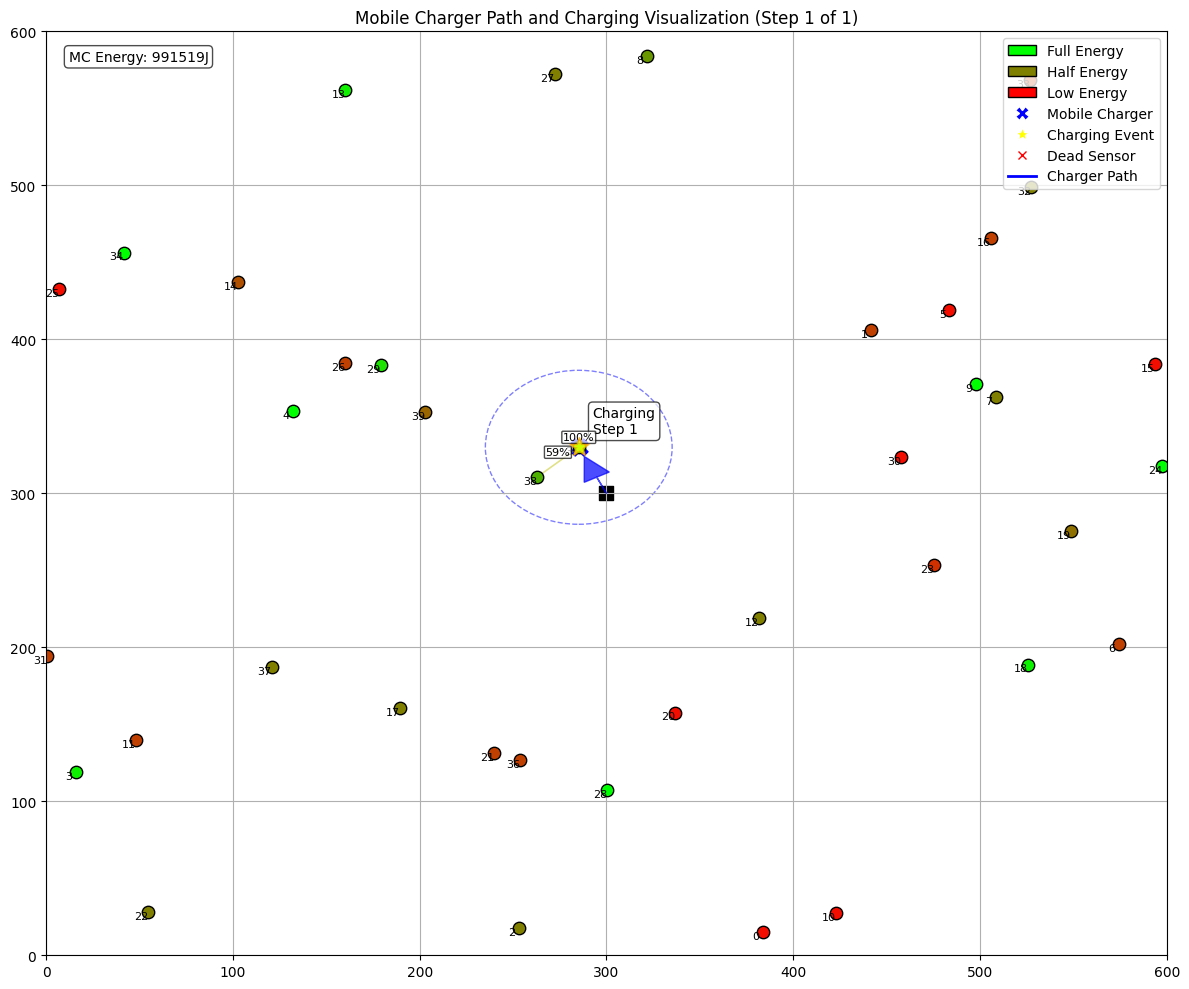

Moving to sensor 30 (5.0% charge)
Charged 1 sensors with 5701.6J of energy
Moving to sensor 23 (18.2% charge)
Charged 1 sensors with 4906.2J of energy
Moving to sensor 5 (5.0% charge)
Charged 2 sensors with 7461.0J of energy
Moving to sensor 15 (4.9% charge)
Charged 1 sensors with 5704.2J of energy
--- Step 6/100 --- MC Energy: 965113.9J
Moving to sensor 20 (4.8% charge)
Charged 1 sensors with 5711.7J of energy
Moving to sensor 0 (4.9% charge)
Charged 2 sensors with 8137.4J of energy
Moving to sensor 25 (4.8% charge)
Charged 1 sensors with 5709.9J of energy
No sensors need charging right now. Letting energy deplete...
No sensors need charging right now. Letting energy deplete...
--- Step 11/100 --- MC Energy: 940280.7J
No sensors need charging right now. Letting energy deplete...
No sensors need charging right now. Letting energy deplete...
No sensors need charging right now. Letting energy deplete...
No sensors need charging right now. Letting energy deplete...
No sensors need chargin

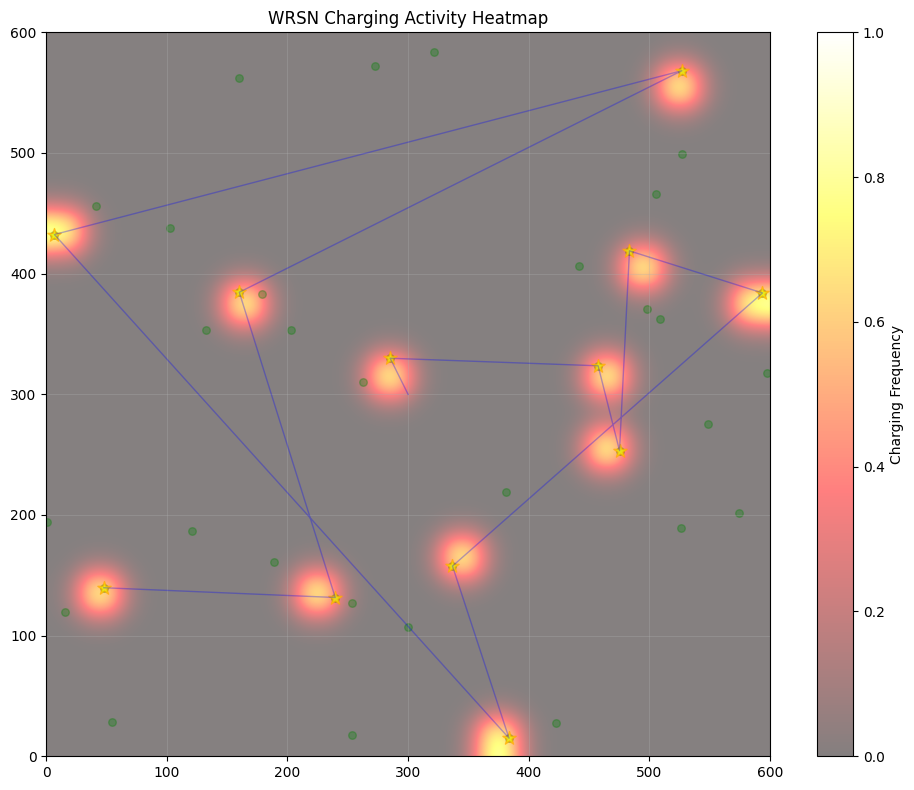

In [276]:
def visualize_extended_charger_path(num_steps=50, time_step=5, visualize_every=5, 
                                    num_sensors=40, random_seed=None):
    """
    Extended visualization of the mobile charger's path and charging behavior.
    
    Args:
        num_steps: Maximum number of simulation steps (higher value = longer simulation)
        time_step: Time between steps in seconds (lower value = slower energy depletion)
        visualize_every: Only show visualization every N steps to reduce output volume
        num_sensors: Number of sensors in the network (more sensors = more charging opportunities)
        random_seed: If set, uses this seed for reproducible simulations
    """
    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize environment with many sensors for better visualization
    sensors, mc = initialize_environment(num_sensors=num_sensors)
    
    # Set energy levels to create more variation in charging needs
    for i, s in enumerate(sensors):
        # Create a mix of charge levels - some urgent, some near threshold, some okay
        if i % 5 == 0:  # 20% of sensors are very low
            s.energy = 0.05 * s.capacity
        elif i % 5 == 1:  # 20% of sensors near threshold
            s.energy = 0.25 * s.capacity
        elif i % 5 == 2:  # 20% of sensors are half charged
            s.energy = 0.5 * s.capacity
            
        # Vary consumption rates 
        s.consumption_rate = random.uniform(0.2, 1.0)  # Lower consumption = longer simulation
    
    # Create storage for path tracking
    path_x = [mc.x]
    path_y = [mc.y]
    charging_events = []
    
    # Track stats
    num_charged_sensors = 0
    total_energy_transferred = 0
    initial_energy = {s.id: s.energy for s in sensors}
    
    # Run extended simulation
    for step in range(num_steps):
        # Update command line output every step
        if step % 5 == 0:
            print(f"--- Step {step+1}/{num_steps} --- MC Energy: {mc.energy:.1f}J")
        
        # Filter sensors needing charging
        to_charge = [s for s in sensors if s.needs_charging()]
        if not to_charge:
            # Add artificial delay between charging rounds
            for s in sensors:
                s.update_energy(time_step * 2)
            print("No sensors need charging right now. Letting energy deplete...")
            # Skip visualization for this step
            continue
            
        # Prioritize based on energy level and distance (weighted approach)
        # This helps create more interesting paths than just choosing closest
        def priority_score(sensor):
            distance = np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y])
            energy_ratio = sensor.energy / sensor.capacity
            # Lower energy and shorter distance = higher priority
            return distance * 0.7 + energy_ratio * 100
            
        to_charge.sort(key=priority_score)
        target = to_charge[0]
        
        # Move to the target sensor
        print(f"Moving to sensor {target.id} ({target.energy/target.capacity:.1%} charge)")
        if not mc.move_to(target.x, target.y):
            print("MC doesn't have enough energy to move.")
            break
            
        # Record path
        path_x.append(mc.x)
        path_y.append(mc.y)
        
        # Charge all sensors within radius
        charged_nodes, energy_amount = mc.charge_nodes_in_radius(sensors)
        
        if charged_nodes:
            total_energy_transferred += energy_amount
            num_charged_sensors += len(charged_nodes)
            print(f"Charged {len(charged_nodes)} sensors with {energy_amount:.1f}J of energy")
            charging_events.append((mc.x, mc.y, step+1))
        
        # Energy consumption for all sensors
        for s in sensors:
            s.update_energy(time_step)
        
        # Visualize at specified intervals or for the final step
        if step % visualize_every == 0 or step == num_steps - 1:
            visualize_path_step(sensors, mc, path_x, path_y, charging_events, step+1)
    
    # Show final energy changes
    final_energy = {s.id: s.energy for s in sensors}
    charged_count = 0
    depleted_count = 0
    
    print("\nEnergy Change Summary:")
    for s_id in initial_energy:
        initial = initial_energy[s_id]
        final = final_energy[s_id]
        change = final - initial
        if change > 0:
            charged_count += 1
        elif change < 0:
            depleted_count += 1
            
        status = "CHARGED" if change > 0 else "DEPLETED" if change < 0 else "UNCHANGED"
        print(f"Sensor {s_id}: {initial:.1f}J → {final:.1f}J ({change:+.1f}J) - {status}")
    
    # Show overall statistics
    print(f"\nOverall Statistics:")
    print(f"Total simulation steps: {num_steps}")
    print(f"Total energy transferred: {total_energy_transferred:.1f}J")
    print(f"Total charging events: {len(charging_events)}")
    print(f"Number of sensors charged at least once: {num_charged_sensors}")
    print(f"Final status: Charged: {charged_count}, Depleted: {depleted_count}")
    print(f"MC remaining energy: {mc.energy:.1f}J")
    
    # Show a heatmap of charging activity
    visualize_charging_heatmap(path_x, path_y, charging_events, sensors)

def visualize_charging_heatmap(path_x, path_y, charging_events, sensors):
    """Creates a heatmap showing where most charging activity occurred"""
    plt.figure(figsize=(10, 8))
    
    # Plot base environment
    plt.scatter([s.x for s in sensors if not s.dead], 
                [s.y for s in sensors if not s.dead], 
                c='green', alpha=0.3, s=30)
    plt.scatter([s.x for s in sensors if s.dead], 
                [s.y for s in sensors if s.dead], 
                c='red', marker='x', s=30)
    
    # Plot path with low opacity
    plt.plot(path_x, path_y, 'b-', alpha=0.3, linewidth=1)
    
    # Create charging event heatmap
    if charging_events:
        charge_x = [x for x, y, _ in charging_events]
        charge_y = [y for x, y, _ in charging_events]
        
        # Use histogram2d to create a heatmap
        heatmap, xedges, yedges = np.histogram2d(charge_x, charge_y, 
                                                bins=[20, 20], 
                                                range=[[0, AREA_WIDTH], [0, AREA_HEIGHT]])
        extent = [0, AREA_WIDTH, 0, AREA_HEIGHT]
        
        plt.imshow(heatmap.T, extent=extent, origin='lower', 
                  cmap='hot', alpha=0.5, interpolation='gaussian')
        plt.colorbar(label='Charging Frequency')
        
        # Plot the charging locations as stars
        plt.scatter(charge_x, charge_y, c='yellow', marker='*', 
                   s=100, edgecolors='orange', alpha=0.7)
    
    plt.title("WRSN Charging Activity Heatmap")
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the extended visualization
visualize_extended_charger_path(
    num_steps=100,       # Run for 100 steps
    time_step=3,         # Slower energy consumption
    visualize_every=10,  # Only show visualization every 10 steps
    num_sensors=40,      # More sensors
    random_seed=42       # Fixed seed for reproducibility
)